In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import dlc_practical_prologue as prologue

import matplotlib.pyplot as plt

if torch.cuda.is_available():  
  dev="cuda:0"
  device = torch.device(dev) 

In [3]:
train_input, train_target, train_classes, test_input, test_target, test_classes = [x.cuda() for x in prologue.generate_pair_sets(1000)]

In [4]:

class Net(nn.Module):
    def __init__(self,nb_hidden):
        super().__init__()
        self.fc1 = nn.Linear(392, nb_hidden)
        self.fc2 = nn.Linear(nb_hidden, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = x.view((x.size(0),-1)) #Vector transformation - Concatenates channels - [v1;v2])
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train_model(model, train_input, train_target, test_input, test_target, lr =1e-3, nb_epochs =25, mini_batch_size= 100, optimizer='SGD',plot=False):
    criterion = nn.CrossEntropyLoss()
    if optimizer=='SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr)
    elif optimizer=='Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)

    loss_train=[]
    loss_test=[]

    for e in range(nb_epochs):
        loss_epoch_train=0
        loss_epoch_test=0
        for b in range(0, train_input.size(0), mini_batch_size):
            output = model(train_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, train_target.narrow(0, b, mini_batch_size))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_epoch_train+=loss.item()

            model.eval()
            output = model(test_input.narrow(0, b, mini_batch_size))
            loss = criterion(output, test_target.narrow(0, b, mini_batch_size))
            loss_epoch_test+=loss.item()
            model.train()

        loss_train.append(loss_epoch_train)
        loss_test.append(loss_epoch_test)
    
    if plot:
        fig, ax1 = plt.subplots()

        ax1.plot(loss_train, c='blue', label='Loss$_{train}$')
        ax1.set_xlabel('# epochs')
        ax2 = ax1.twinx()
        ax2.plot(loss_test, c='orange', label='Loss$_{test}$')
        #Allows to have legends in same box https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')
        plt.show()
  

In [6]:
def compute_nb_errors(model, data_input, data_target, mini_batch_size= 100):

    nb_data_errors = 0
    for b in range(0, data_input.size(0), mini_batch_size):
        batch_input  = data_input.narrow(0, b, mini_batch_size)
        batch_target = data_target.narrow(0, b, mini_batch_size)
        
        output = model(batch_input)
        predicted_classes = torch.argmax(output, 1)
 
        nb_data_errors += (predicted_classes != batch_target).sum()

    return nb_data_errors

Number of neurons in hidden layer : 50 


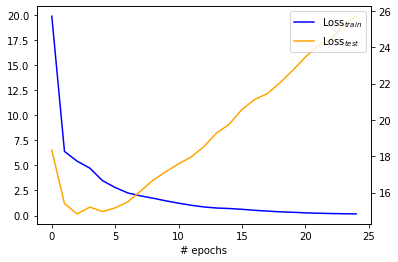

Mean train_error 0.22%	 Mean test_error 21.56%
STD train_error 0.33%	 STD test_error 1.14%

Number of neurons in hidden layer : 100 


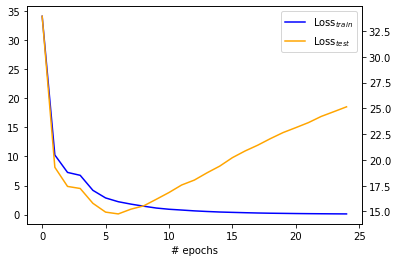

Mean train_error 0.02%	 Mean test_error 21.54%
STD train_error 0.04%	 STD test_error 1.60%

Number of neurons in hidden layer : 150 


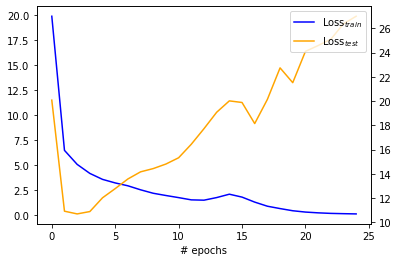

Mean train_error 0.16%	 Mean test_error 20.46%
STD train_error 0.18%	 STD test_error 1.66%

Number of neurons in hidden layer : 200 


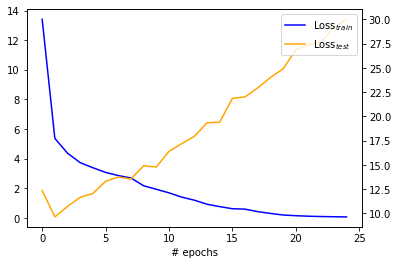

Mean train_error 0.16%	 Mean test_error 20.30%
STD train_error 0.15%	 STD test_error 0.95%

Number of neurons in hidden layer : 300 


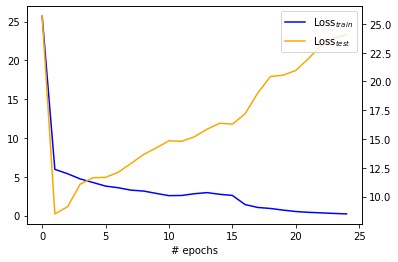

Mean train_error 7.68%	 Mean test_error 23.36%
STD train_error 10.34%	 STD test_error 5.17%

Number of neurons in hidden layer : 400 


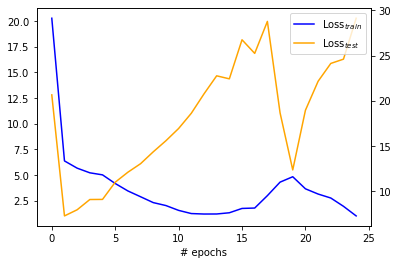

Mean train_error 0.84%	 Mean test_error 19.48%
STD train_error 1.77%	 STD test_error 0.66%

Number of neurons in hidden layer : 500 


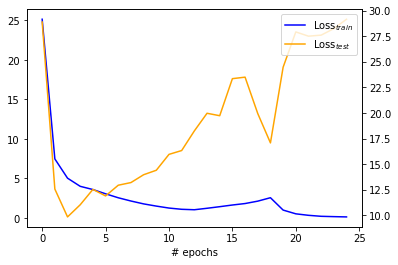

Mean train_error 2.58%	 Mean test_error 20.16%
STD train_error 3.30%	 STD test_error 1.48%

The best # of hidden neurons is : 400


In [7]:

error=[]
for nb_hidden in [50,100,150,200,300,400,500]:
    train_E=[]
    test_E=[]
    print(f'Number of neurons in hidden layer : {nb_hidden} ')
    plot=False
    for i in range(5):
        if i==4: plot=True

        model=Net(nb_hidden).cuda()
        train_model(model,train_input,train_target,test_input,train_target,optimizer='Adam',plot=plot)
        train_E.append(compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100)
        test_E.append(compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100)

    train_E=torch.tensor(train_E)
    test_E=torch.tensor(test_E)    
    print('Mean train_error {:.02f}%\t Mean test_error {:.02f}%'.format(train_E.mean(),test_E.mean()))
    print('STD train_error {:.02f}%\t STD test_error {:.02f}%\n'.format(train_E.std(),test_E.std()))
    error.append(test_E.mean())
    
error=torch.tensor(error)
best_parameter=[50,100,150,200,300,400,500][error.argmin()]
print(f'The best # of hidden neurons is : {best_parameter}')

Number of epochs : 5 


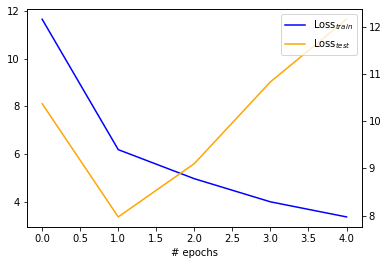

Mean train_error 15.02%	 Mean test_error 23.38%
STD train_error 3.74%	 STD test_error 1.58%

Number of epochs : 10 


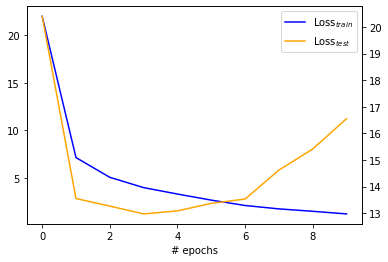

Mean train_error 1.82%	 Mean test_error 22.70%
STD train_error 1.11%	 STD test_error 1.78%

Number of epochs : 25 


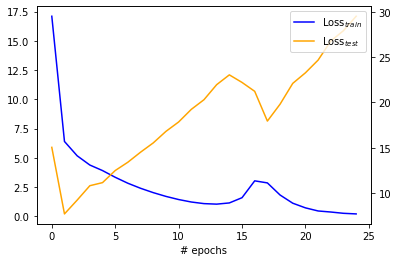

Mean train_error 0.64%	 Mean test_error 21.28%
STD train_error 1.27%	 STD test_error 1.53%

Number of epochs : 50 


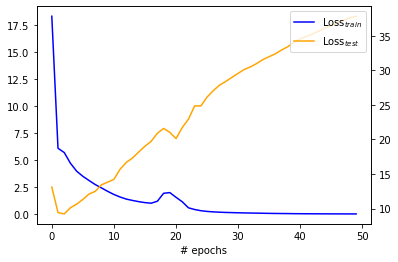

Mean train_error 0.00%	 Mean test_error 20.84%
STD train_error 0.00%	 STD test_error 1.08%

Number of epochs : 100 


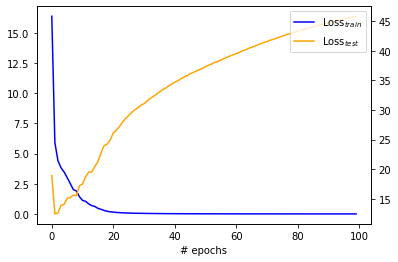

Mean train_error 0.02%	 Mean test_error 21.08%
STD train_error 0.04%	 STD test_error 1.95%

The best # of epochs is : 50


In [8]:
error=[]
for nb_epochs in [5,10,25,50,100]:
    train_E=[]
    test_E=[]
    print(f'Number of epochs : {nb_epochs} ')
    plot=False

    for i in range(5):
        if i==4: plot=True

        model=Net(100).cuda()
        train_model(model,train_input,train_target,test_input,train_target,optimizer='Adam', nb_epochs=nb_epochs, plot=plot)
        train_E.append(compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100)
        test_E.append(compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100)

    train_E=torch.tensor(train_E)
    test_E=torch.tensor(test_E)    
    print('Mean train_error {:.02f}%\t Mean test_error {:.02f}%'.format(train_E.mean(),test_E.mean()))
    print('STD train_error {:.02f}%\t STD test_error {:.02f}%\n'.format(train_E.std(),test_E.std()))
    error.append(test_E.mean())
    
error=torch.tensor(error)
best_parameter=[5,10,25,50,100][error.argmin()]
print(f'The best # of epochs is : {best_parameter}')

Learning rate : 1e-05	 Optimizer : Adam


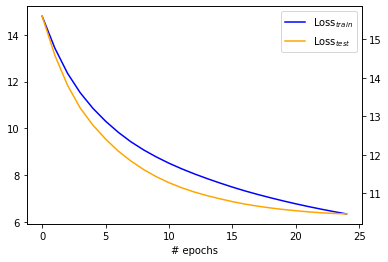

Mean train_error 35.04%	 Mean test_error 38.88%
STD train_error 6.76%	 STD test_error 4.87%

Learning rate : 0.0001	 Optimizer : Adam


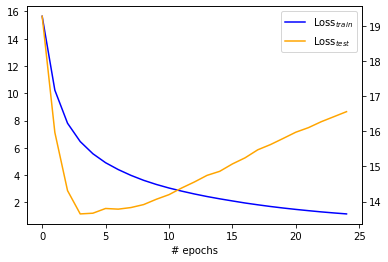

Mean train_error 4.20%	 Mean test_error 26.02%
STD train_error 2.32%	 STD test_error 1.85%

Learning rate : 0.001	 Optimizer : Adam


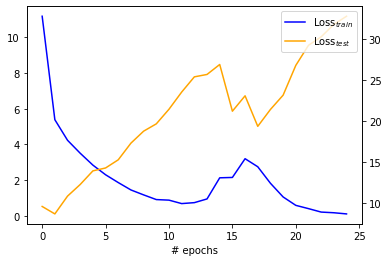

Mean train_error 2.20%	 Mean test_error 21.50%
STD train_error 4.75%	 STD test_error 2.35%

Learning rate : 0.01	 Optimizer : Adam


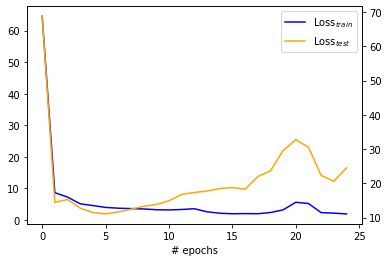

Mean train_error 24.70%	 Mean test_error 35.06%
STD train_error 18.48%	 STD test_error 11.28%

Learning rate : 0.1	 Optimizer : Adam


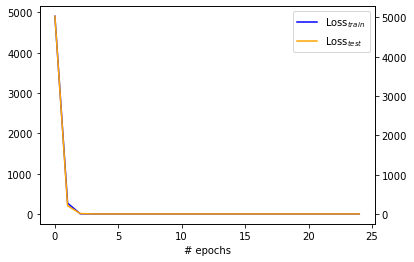

Mean train_error 44.90%	 Mean test_error 47.40%
STD train_error 0.00%	 STD test_error 0.00%

The best learning rate with Adam is : 0.001


In [9]:
error=[]
for lr in [1e-5,1e-4,1e-3,1e-2,1e-1]:
    train_E=[]
    test_E=[]
    print(f'Learning rate : {lr}\t Optimizer : Adam')
    plot=False

    for i in range(5):
        if i==4: plot=True

        model=Net(100).cuda()
        train_model(model,train_input,train_target,test_input,train_target,optimizer='Adam',lr=lr, plot=plot)
        train_E.append(compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100)
        test_E.append(compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100)

    train_E=torch.tensor(train_E)
    test_E=torch.tensor(test_E)    
    print('Mean train_error {:.02f}%\t Mean test_error {:.02f}%'.format(train_E.mean(),test_E.mean()))
    print('STD train_error {:.02f}%\t STD test_error {:.02f}%\n'.format(train_E.std(),test_E.std()))
    error.append(test_E.mean())
    
error=torch.tensor(error)
best_parameter=[1e-5,1e-4,1e-3,1e-2,1e-1][error.argmin()]
print(f'The best learning rate with Adam is : {best_parameter}')


Learning rate : 1e-05	 Optimizer : SGD


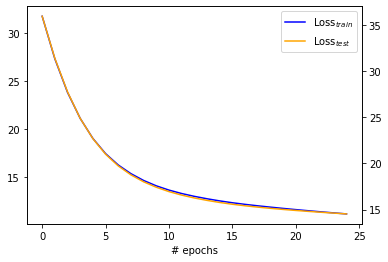

Mean train_error 45.46%	 Mean test_error 45.56%
STD train_error 4.02%	 STD test_error 3.11%

Learning rate : 0.0001	 Optimizer : SGD


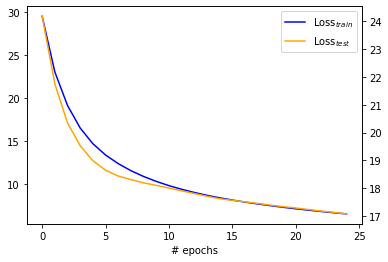

Mean train_error 28.28%	 Mean test_error 33.98%
STD train_error 3.77%	 STD test_error 1.38%

Learning rate : 0.001	 Optimizer : SGD


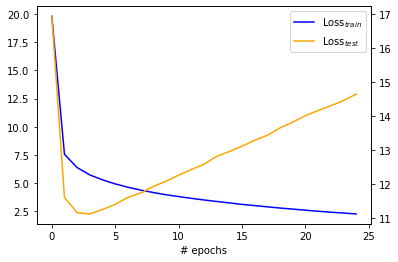

Mean train_error 7.68%	 Mean test_error 26.40%
STD train_error 2.75%	 STD test_error 2.11%

Learning rate : 0.01	 Optimizer : SGD


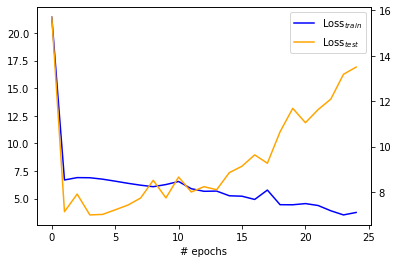

Mean train_error 24.14%	 Mean test_error 30.64%
STD train_error 15.65%	 STD test_error 10.06%

Learning rate : 0.1	 Optimizer : SGD


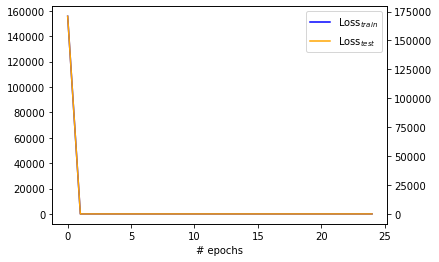

Mean train_error 44.88%	 Mean test_error 47.44%
STD train_error 0.04%	 STD test_error 0.05%

The best learning rate with SGD is : 0.001


In [10]:
error=[]
for lr in [1e-5,1e-4,1e-3,1e-2,1e-1]:
    train_E=[]
    test_E=[]
    print(f'Learning rate : {lr}\t Optimizer : SGD')
    plot=False

    for i in range(5):
        if i==4: plot=True

        model=Net(100).cuda()
        train_model(model,train_input,train_target,test_input,train_target,optimizer='SGD',lr=lr, plot=plot)
        train_E.append(compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100)
        test_E.append(compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100)

    train_E=torch.tensor(train_E)
    test_E=torch.tensor(test_E)    
    print('Mean train_error {:.02f}%\t Mean test_error {:.02f}%'.format(train_E.mean(),test_E.mean()))
    print('STD train_error {:.02f}%\t STD test_error {:.02f}%\n'.format(train_E.std(),test_E.std()))
    error.append(test_E.mean())
    
error=torch.tensor(error)
best_parameter=[1e-5,1e-4,1e-3,1e-2,1e-1][error.argmin()]
print(f'The best learning rate with SGD is : {best_parameter}')

Mini batch size: 50


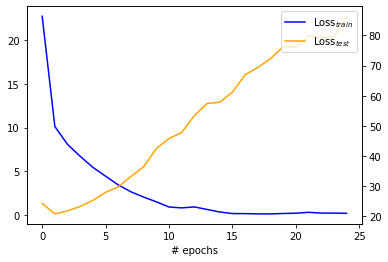

Mean train_error 5.28%	 Mean test_error 25.00%
STD train_error 4.99%	 STD test_error 3.82%

Mini batch size: 100


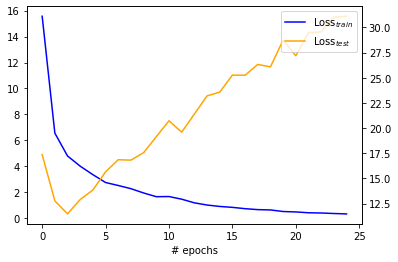

Mean train_error 0.22%	 Mean test_error 21.08%
STD train_error 0.38%	 STD test_error 1.99%

Mini batch size: 200


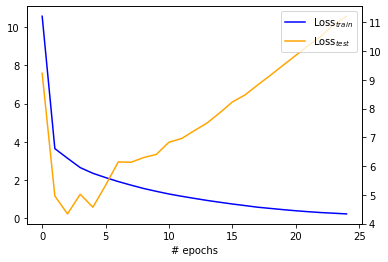

Mean train_error 0.78%	 Mean test_error 22.48%
STD train_error 1.20%	 STD test_error 1.46%

Mini batch size: 500


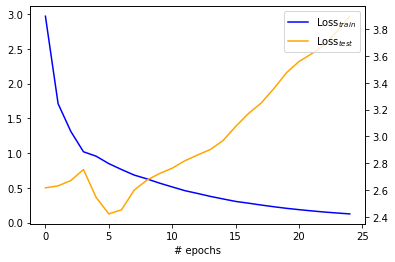

Mean train_error 3.56%	 Mean test_error 22.48%
STD train_error 4.59%	 STD test_error 0.59%

Mini batch size: 1000


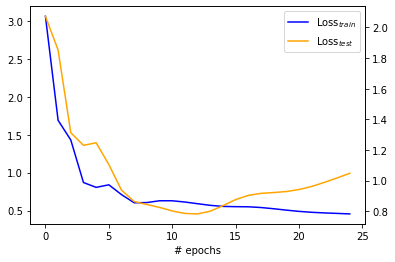

Mean train_error 19.42%	 Mean test_error 25.02%
STD train_error 6.65%	 STD test_error 2.32%

The best mini batch size is : 100


In [11]:
error=[]
for mini_batch_size in [50,100,200,500,1000]:
    train_E=[]
    test_E=[]
    print(f'Mini batch size: {mini_batch_size}')
    plot=False

    for i in range(5):
        if i==4: plot=True

        model=Net(100).cuda()
        train_model(model,train_input,train_target,test_input,train_target,optimizer='Adam',mini_batch_size=mini_batch_size, plot=plot)
        train_E.append(compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100)
        test_E.append(compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100)

    train_E=torch.tensor(train_E)
    test_E=torch.tensor(test_E)    
    print('Mean train_error {:.02f}%\t Mean test_error {:.02f}%'.format(train_E.mean(),test_E.mean()))
    print('STD train_error {:.02f}%\t STD test_error {:.02f}%\n'.format(train_E.std(),test_E.std()))
    error.append(test_E.mean())
    
error=torch.tensor(error)
best_parameter=[50,100,200,500,1000][error.argmin()]
print(f'The best mini batch size is : {best_parameter}')

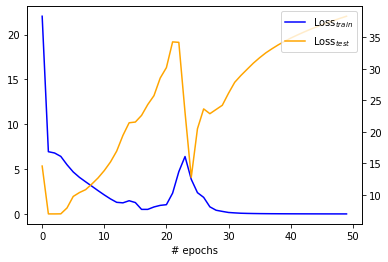

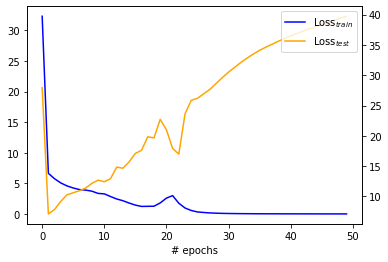

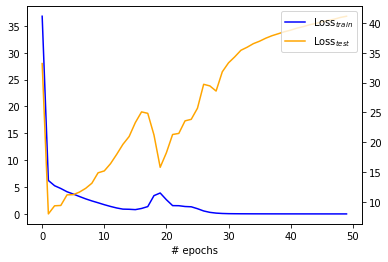

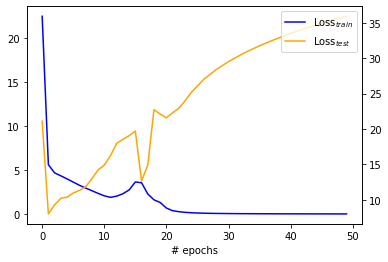

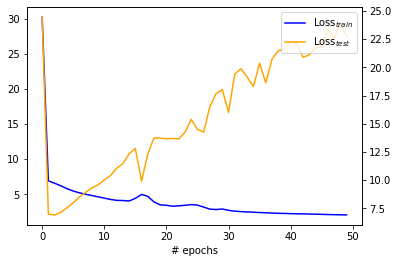

Mean train_error 0.74%	 Mean test_error 20.08%
STD train_error 1.65%	 STD test_error 1.24%



In [15]:


train_E=[]
test_E=[]
plot=False

for i in range(5):
    model=Net(nb_hidden=400).cuda()
    train_model(model,train_input,train_target,test_input,train_target,\
        optimizer='Adam', mini_batch_size=100,\
        lr=1e-3,nb_epochs=50,plot=True)
    train_E.append(compute_nb_errors(model, train_input, train_target) / train_input.size(0) * 100)
    test_E.append(compute_nb_errors(model, test_input, test_target) / test_input.size(0) * 100)

train_E=torch.tensor(train_E)
test_E=torch.tensor(test_E)    
print('Mean train_error {:.02f}%\t Mean test_error {:.02f}%'.format(train_E.mean(),test_E.mean()))
print('STD train_error {:.02f}%\t STD test_error {:.02f}%\n'.format(train_E.std(),test_E.std()))